[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/hendersonneurolab/CogAI_Fall2025/blob/master/Lab03_StyleTransfer.ipynb)

## Week 3: Style Transfer with CNNs

In this tutorial, we'll implement a version of style transfer: a neural network algorithm for mapping the style of one image onto the content of another image.

1. Start with a pre-trained CNN (VGG-19), modify it by adding a "style loss" and a "content loss".
2. Optimize an image to minimize these losses.
3. Explore the possible images that can be created.

**Learning objectives:**
- Know the difference between "style" (i.e., texture) and "content" (i.e., shape), and how these are computed from CNN activations.
- Understand how we can use image optimization (via gradient descent) to generate synthetic images.




Credit: This code was adapted from a [PyTorch tutorial](https://docs.pytorch.org/tutorials/advanced/neural_style_tutorial.html)

**Original Author**: [Alexis Jacq](https://alexis-jacq.github.io)

**Edited by**: [Winston Herring](https://github.com/winston6)


In [1]:
# Import what we need: torch, torchvision
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
from torchvision.models import vgg19, VGG19_Weights

import copy
import requests
import os

# Check if CUDA (GPU) is available - this will speed up training significantly
# If it says "cpu", use the menu at top right to select: "change runtime type"
# Then choose: T4 GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')
if torch.cuda.is_available():
    print(f'GPU: {torch.cuda.get_device_name(0)}')


Using device: cuda
GPU: Tesla T4


##Step 1: Load the style and content images

We're going to implement the ["neural algorithm of artistic style"](https://arxiv.org/abs/1508.06576). This is a CNN-based algorithm that generates an image with the "style" of one image, and the "content" of another.

To do this, we need a style source image and a content source image.

Let's start with some examples for now.

In [2]:
# First, mount your Google Drive (if not already mounted)
from google.colab import drive
drive.mount('/content/drive')

# Navigate to the Colab Notebooks folder
colab_notebooks_path = '/content/drive/MyDrive/Colab Notebooks/'
os.chdir(colab_notebooks_path)
os.makedirs('CogAI', exist_ok=True)
os.makedirs('CogAI/images', exist_ok=True)

images_folder = os.path.join(colab_notebooks_path, 'CogAI', 'images')
print(images_folder)

Mounted at /content/drive
/content/drive/MyDrive/Colab Notebooks/CogAI/images


In [3]:
# Helper function for image downloads
def download_image(url, filepath):
    try:
        headers = {
              'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36'
          }
        response = requests.get(url, headers=headers, timeout=10)
        # response = requests.get(url, timeout=10)
        response.raise_for_status()  # Raises exception for bad status codes

        # Verify it's an image
        content_type = response.headers.get('content-type', '')
        if not content_type.startswith('image/'):
            print(f"Warning: Content-Type is {content_type}, not an image")
            return False

        with open(filepath, 'wb') as f:
            f.write(response.content)

        # Verify file size
        if os.path.getsize(filepath) < 100:  # Very small files are likely errors
            print("Warning: Downloaded file is suspiciously small")
            return False

        return True

    except requests.exceptions.RequestException as e:
        print(f"Request failed: {e}")
        return False

In [4]:
# Your image URLs
# These are just images from the internet - you can use your own too.
image_urls = ["https://apollo-magazine.com/wp-content/uploads/2021/09/Web-lead-image_FINAL_art_diary2.jpg?w=1000", \
              "https://birdlifedata.blob.core.windows.net/species-images/22697748.jpg"]
names = ['Style_Cubism.jpg','Content_Penguin.jpg']

for url, name in zip(image_urls, names):

  # filename = url.split(os.sep)[-1]
  file_path = os.path.join(images_folder, name)

  file_path = os.path.join(images_folder, name)
  print(file_path)
  success = download_image(url, file_path)
  print('Success = %s'%success)


/content/drive/MyDrive/Colab Notebooks/CogAI/images/Style_Cubism.jpg
Success = True
/content/drive/MyDrive/Colab Notebooks/CogAI/images/Content_Penguin.jpg
Success = True


Now let's create some code to process the images. We need to resize them to the same size.

In [5]:
# desired size of the output image
imsize = 512 if torch.cuda.is_available() else 128  # use small size if no GPU

loader = transforms.Compose([
    transforms.Resize(imsize),  # scale imported image
    transforms.CenterCrop(imsize),  # crop imported image
    transforms.ToTensor()])  # transform it into a torch tensor


def image_loader(image_name):
    image = Image.open(image_name)
    # fake batch dimension required to fit network's input dimensions
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)

style_image_path = os.path.join(images_folder, "Style_Cubism.jpg")
content_image_path = os.path.join(images_folder, "Content_Penguin.jpg")
print('Style image: %s'%style_image_path)
print('Content image: %s'%content_image_path)

style_img = image_loader(style_image_path)
content_img = image_loader(content_image_path)

assert style_img.size() == content_img.size(), \
    "we need to import style and content images of the same size"

Style image: /content/drive/MyDrive/Colab Notebooks/CogAI/images/Style_Cubism.jpg
Content image: /content/drive/MyDrive/Colab Notebooks/CogAI/images/Content_Penguin.jpg


Now, let\'s create a function that displays an image, to ensure they're loaded correctly.


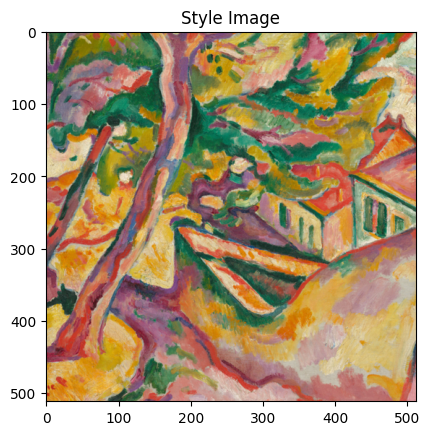

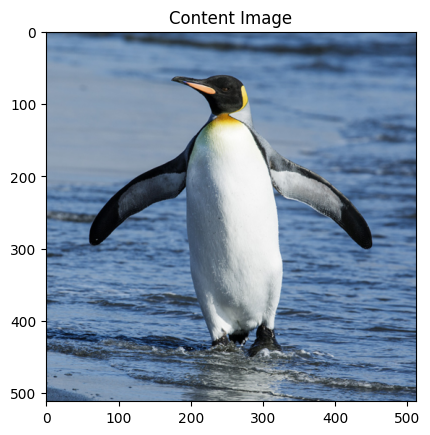

In [6]:
unloader = transforms.ToPILImage()  # reconvert into PIL image

plt.ion()

def imshow(tensor, title=None):
    image = tensor.cpu().clone()  # we clone the tensor to not do changes on it
    image = image.squeeze(0)      # remove the fake batch dimension
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) # pause a bit so that plots are updated


plt.figure()
imshow(style_img, title='Style Image')

plt.figure()
imshow(content_img, title='Content Image')

##Step 2: Load the CNN

To run style transfer, we will start with a pre-trained CNN model. We'll then modify it to support our algorithm. The reason for using an already-trained model here is that it has already learned complex and descriptive image features during its training. Therefore, we can use these learned features in order to guide our synthesis procedure toward complex image properties.

As in the original paper, we'll use a pre-trained
[VGG-19](https://docs.pytorch.org/vision/main/models/generated/torchvision.models.vgg19.html) model -- but in principle, any CNN would work.


In [7]:
cnn = vgg19(weights=VGG19_Weights.DEFAULT).features.eval()
cnn = cnn.to(device)
cnn

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


100%|██████████| 548M/548M [00:08<00:00, 71.2MB/s]


Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

Check out the number of layers. Why do we think it's called VGG-19?


PyTorch's implementation of VGG is a module divided into two child
`Sequential` modules: `features` (containing convolution and pooling
layers), and `classifier` (containing fully connected layers). We will
use the `features` module because we need the output of the individual
convolution layers to measure content and style loss. Some layers have
different behavior during training than evaluation, so we must set the
network to evaluation mode using `.eval()`.



Next, we need to set up a module for image normalization, which is another image pre-processing step. VGG networks are trained on images with each channel
normalized by mean=\[0.485, 0.456, 0.406\] and std=\[0.229, 0.224,
0.225\]. We will use them to normalize the image before sending it into
the network.


In [8]:
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

# create a module to normalize input image so we can easily put it in a
# ``nn.Sequential``
class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        # .view the mean and std to make them [C x 1 x 1] so that they can
        # directly work with image Tensor of shape [B x C x H x W].
        # B is batch size. C is number of channels. H is height and W is width.
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)

    def forward(self, img):
        # normalize ``img``
        return (img - self.mean) / self.std

##Step 3: Create the loss functions

To synthesize our target image, we're aiming to minimize the loss (i.e., difference) between our "source" images which we just loaded, and the generated image that we're working on optimizing. The loss is defined in two parts:

- **Content loss:** This captures the distance between feature maps corresponding to source and input images, at a specified set of network layers.  
  - For content loss we use deeper CNN layers, because they retain more high-level object & scene content.
  - Content loss *takes into account spatial position* -- it retains which features are where.
- **Style loss:** This captures the distances between Gram matrices (computed from feature maps) corresponding to source and target images.
  - Gram matrix: based on dot product between different CNN feature maps at a given layer (see later sections for more).
  - Style loss *discards spatial position* -- it only retains "texture-like" information about which features are present anywhere. Like a "summary statistic" representation.

As we optimize the image, each of these losses will go down, as the image becomes more aligned with each of the source images.


####First, compute the content loss:

This is a new module that we're going to attach to the end of the CNN layers in our pre-trained model. It computes the content distance based on that layer.

To get this, we'll compute mean-squared error (MSE) between the feature maps for our source content image ($C$) and our input image ($X$), as:
$\|F_{XL} - F_{CL}\|^2$

Where $F_{XL}$
 is the feature map from layer $L$ processing input $X$, and $F_{CL}$ is the feature map from layer $L$ processing input $C$. This can be computed using `nn.MSELoss`.

The total content loss will be computed as a weighted sum of the content distance (MSE) for individual layers.

We will add this content loss module directly after the convolution
layer(s) that are being used to compute the content distance. This way
each time the network is fed an input image, the content losses will be
computed at the desired layers and because of autograd, all the
gradients will be computed. Now, in order to make the content loss layer
transparent we must define a `forward` method that computes the content
loss and then returns the layer's input. The computed loss is saved as a
parameter of the module.


In [9]:
class ContentLoss(nn.Module):

    def __init__(self, target,):
        super(ContentLoss, self).__init__()
        # we 'detach' the target content from the tree used
        # to dynamically compute the gradient: this is a stated value,
        # not a variable. Otherwise the forward method of the criterion
        # will throw an error.
        self.target = target.detach()

    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input

####Next, compute the style loss:

The style loss module is implemented similarly to the content loss
module. It will be attached to CNN layers to compute
the style loss of each layer.

In order to calculate the style loss, we
need to compute the **gram matrix $G_{XL}$**. A gram matrix is the result of
multiplying a given matrix by its transposed matrix. In this application,
the given matrix is a reshaped version of the feature maps $F_{XL}$ of a
layer $L$. $F_{XL}$ is reshaped to form $\hat{F}_{XL}$, a $K$x$N$
matrix, where $K$ is the number of feature maps at layer $L$ and $N$ is
the length of any vectorized feature map $F_{XL}^k$. For example, the
first line of $\hat{F}_{XL}$ corresponds to the first vectorized feature
map $F_{XL}^1$.

We then compute $\hat{F}_{XL} \cdot \hat{F}_{XL}^T$

Finally, the gram matrix must be normalized by dividing each element by
the total number of elements in the matrix. This normalization is to
counteract the fact that $\hat{F}_{XL}$ matrices with a large $N$
dimension yield larger values in the Gram matrix. These larger values
will cause the first layers (before pooling layers) to have a larger
impact during the gradient descent. Style features tend to be in the
deeper layers of the network so this normalization step is crucial.

$G_{XL}$ is now  [$K$ x $K$], where $K$ is the number of feature maps. Notice, it no longer has a spatial dimension!


Intuitively: the gram matrix takes a dot product between each pair of feature maps, looking at how correlated they are. This is like asking: how much do the different CNN feature maps each align with one another? Which pairs of feature maps spatially co-occur?

In [10]:
def gram_matrix(input):
    a, b, c, d = input.size()  # a=batch size(=1)
    # b=number of feature maps
    # (c,d)=dimensions of a f. map (N=c*d)

    features = input.view(a * b, c * d)  # resize F_XL into \hat F_XL

    G = torch.mm(features, features.t())  # compute the gram product

    # we 'normalize' the values of the gram matrix
    # by dividing by the number of element in each feature maps.
    return G.div(a * b * c * d)

Now the style loss module looks almost exactly like the content loss
module. The style distance is also computed using the mean square error
between $G_{XL}$ and $G_{SL}$.


In [11]:
class StyleLoss(nn.Module):

    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach()

    def forward(self, input):
        G = gram_matrix(input)
        self.loss = F.mse_loss(G, self.target)
        return input

Next, let's make a function to compute these losses, and combine them across layers.

A `Sequential` module contains an ordered list of child modules. For
instance, `vgg19.features` contains a sequence (`Conv2d`, `ReLU`,
`MaxPool2d`, `Conv2d`, `ReLU`...) aligned in the right order of depth.
We need to add our content loss and style loss layers immediately after
the convolution layer they are detecting. To do this we must create a
new `Sequential` module that has content loss and style loss modules
correctly inserted.


In [12]:
# desired depth layers to compute style/content losses :
content_layers_default = ['conv_4']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

# ^ you can try changing the above to a different set of layers
# and see how the results differ...


def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                               style_img, content_img,
                               content_layers=content_layers_default,
                               style_layers=style_layers_default):
    # normalization module
    normalization = Normalization(normalization_mean, normalization_std)

    # just in order to have an iterable access to or list of content/style
    # losses
    content_losses = []
    style_losses = []

    # assuming that ``cnn`` is a ``nn.Sequential``, so we make a new ``nn.Sequential``
    # to put in modules that are supposed to be activated sequentially
    model = nn.Sequential(normalization)

    i = 0  # increment every time we see a conv
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            # The in-place version doesn't play very nicely with the ``ContentLoss``
            # and ``StyleLoss`` we insert below. So we replace with out-of-place
            # ones here.
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

        model.add_module(name, layer)

        if name in content_layers:
            # add content loss:
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module("content_loss_{}".format(i), content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            # add style loss:
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module("style_loss_{}".format(i), style_loss)
            style_losses.append(style_loss)

    # now we trim off the layers after the last content and style losses
    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break

    model = model[:(i + 1)]

    return model, style_losses, content_losses

##Step 4: Synthesize the image

To create our desired image, the first step is to start with an input.
Let's try starting with a random image here. You can also experiment with starting from something else, like the content image itself. Sometimes starting from a real image can give better results.

From this starting image, we will iteratively perturb it, meaning we'll slowly change its pixels step-by-step. We'll continue until it turns into what we're looking for.


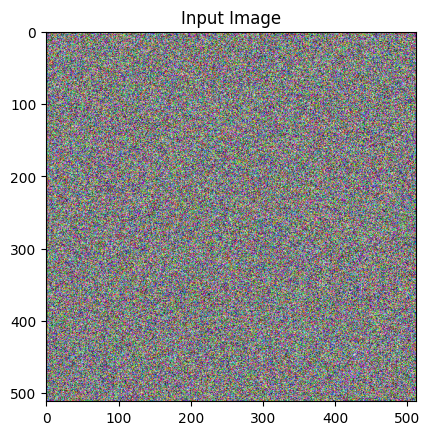

In [13]:
input_img = torch.randn(content_img.data.size()).to(device)
# input_img = content_img.clone()

# add the original input image to the figure:
plt.figure()
imshow(input_img, title='Input Image')

Next, we'll create our optimizer. This is the algorithm that tells us how to update the image pixels based on the loss function, using gradient descent.

Here, we're using the [L-BFGS](https://docs.pytorch.org/docs/stable/generated/torch.optim.LBFGS.html) optimizer, which works well for image synthesis.

**Important note:** This is different from how optimization works when we are training a neural network. In the usual case of network training (like we did last week), we were updating the *weights* of the model in response to images. Here, we're actually leaving the model weights unchanged, and we're updating the image *pixels*. The model stays the same, but our image will change into something new!


In [14]:
def get_input_optimizer(input_img):
    # this line to show that input is a parameter that requires a gradient
    optimizer = optim.LBFGS([input_img])
    return optimizer

Now let's create a function to put this all together.

Similarly to model training... we'll make a loop over training steps. At each step, we'll get the loss (based on our style and content losses defined above). We'll use the ``optimizer.backward()`` function to compute gradients. The gradients tell us how much to change the input image, to decrease the loss.

This particular optimizer requires that we define a "closure" function, which gets called during optimization. It re-evaluates the model and returns the loss.

We still have one final constraint to address. The network may try to
optimize the input with values that exceed the 0 to 1 tensor range for
the image. We can address this by correcting the input values to be
between 0 to 1 each time the network is run.


In [15]:
def run_style_transfer(cnn, normalization_mean, normalization_std,
                       content_img, style_img, input_img, num_steps=300,
                       style_weight=1000000, content_weight=1, \
                       content_layers=content_layers_default,
                       style_layers=style_layers_default
                       ):
    """Run the style transfer."""
    print('Building the style transfer model..')
    model, style_losses, content_losses = get_style_model_and_losses(cnn,
        normalization_mean, normalization_std, style_img, content_img, \
        content_layers=content_layers,
        style_layers=style_layers)

    # We want to optimize the input and not the model parameters so we
    # update all the requires_grad fields accordingly
    input_img.requires_grad_(True)
    # We also put the model in evaluation mode, so that specific layers
    # such as dropout or batch normalization layers behave correctly.
    model.eval()
    model.requires_grad_(False)

    optimizer = get_input_optimizer(input_img)

    print('Optimizing..')
    run = [0]
    while run[0] <= num_steps:

        def closure():
            # correct the values of updated input image
            with torch.no_grad():
                input_img.clamp_(0, 1)

            optimizer.zero_grad()
            model(input_img)
            style_score = 0
            content_score = 0

            for sl in style_losses:
                style_score += sl.loss
            for cl in content_losses:
                content_score += cl.loss

            # print(style_score, content_score)
            style_score *= style_weight
            content_score *= content_weight

            loss = style_score + content_score
            loss.backward()
            # compute the gradients here.

            run[0] += 1
            if run[0] % 50 == 0:
                print("run {}:".format(run))
                print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                    style_score.item(), content_score.item()))
                print()

            return style_score + content_score

        optimizer.step(closure)
        # this is the optimizer function.
        # In here is where the actual pixel values get updated at each step.
        # The optimizer algorithm determines how and when to do those updates.

    # a last correction...
    with torch.no_grad():
        input_img.clamp_(0, 1)

    return input_img

Finally, we can run the algorithm.

TIP: make sure you're attached to the GPU for this! It will take a very long time on a CPU.

(upper right dropdown menu > change runtime type > T4 GPU)


Building the style transfer model..


/tmp/ipython-input-3448458484.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.mean = torch.tensor(mean).view(-1, 1, 1)
/tmp/ipython-input-3448458484.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.std = torch.tensor(std).view(-1, 1, 1)


Optimizing..


/usr/local/lib/python3.12/dist-packages/torch/optim/lbfgs.py:457: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at /pytorch/torch/csrc/autograd/generated/python_variable_methods.cpp:835.)
  loss = float(closure())


run [50]:
Style Loss : 259.691803 Content Loss: 320.969177

run [100]:
Style Loss : 94.803589 Content Loss: 243.266632

run [150]:
Style Loss : 58.007557 Content Loss: 202.034424

run [200]:
Style Loss : 39.700333 Content Loss: 177.904022

run [250]:
Style Loss : 28.758965 Content Loss: 163.404541

run [300]:
Style Loss : 21.183149 Content Loss: 154.251144



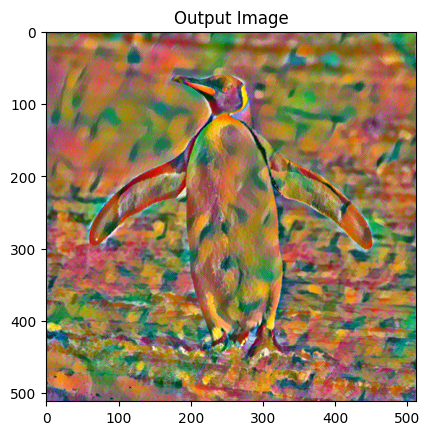

In [16]:
output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, input_img, style_weight = 10**6, content_weight=10)

plt.figure()
imshow(output, title='Output Image')

plt.ioff()
plt.show()

## Step 5: Try it yourself


---
***Question 1:***


Try uploading your own images:

Navigate to: https://drive.google.com/drive/my-drive

Then navigate to "Colab Notebooks > CogAI > images"

In this folder, you should see the files "Style_Cubism.jpg", and "Content_Penguin.jpg"

Now upload your own images here: one for style, and one for content.


Style image: /content/drive/MyDrive/Colab Notebooks/CogAI/images/Style_Surrealism.jpg
Content image: /content/drive/MyDrive/Colab Notebooks/CogAI/images/Content_Puppy.jpg


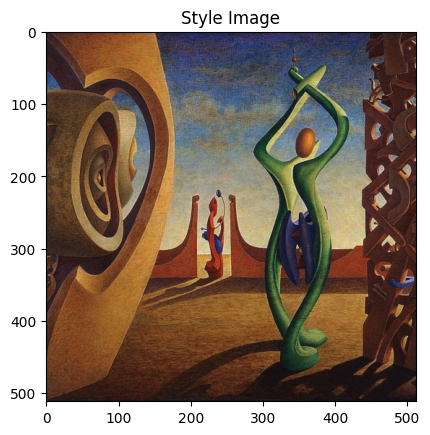

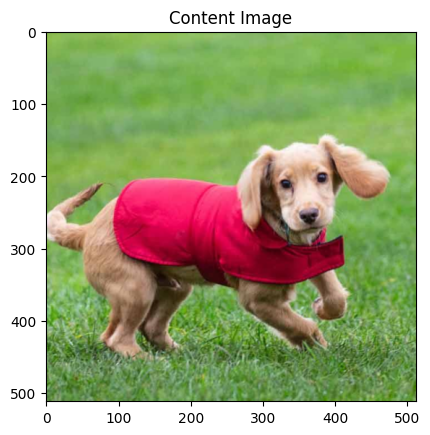

In [18]:
# modify these paths:
style_image_path = os.path.join(images_folder, "Style_Surrealism.jpg")
content_image_path = os.path.join(images_folder, "Content_Puppy.jpg")
# style_image_path = os.path.join(images_folder, "Cat1.jpg")
# content_image_path = os.path.join(images_folder, "Cat2.jpg")

print('Style image: %s'%style_image_path)
print('Content image: %s'%content_image_path)

style_img = image_loader(style_image_path)
content_img = image_loader(content_image_path)

plt.figure()
imshow(style_img, title='Style Image')

plt.figure()
imshow(content_img, title='Content Image')

In [19]:
input_img = torch.randn(content_img.data.size()).to(device)
output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, input_img, style_weight = 10**6, content_weight=10)

plt.figure()
imshow(output, title='Output Image')

plt.ioff()
plt.show()

Building the style transfer model..
Optimizing..


/tmp/ipython-input-3448458484.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.mean = torch.tensor(mean).view(-1, 1, 1)
/tmp/ipython-input-3448458484.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.std = torch.tensor(std).view(-1, 1, 1)


run [50]:
Style Loss : 140.342728 Content Loss: 206.448395

run [100]:
Style Loss : 51.717098 Content Loss: 141.798279

run [150]:
Style Loss : 22.889881 Content Loss: 114.687988

run [200]:
Style Loss : 15.627814 Content Loss: 100.550018



KeyboardInterrupt: 

If you get an image you like, save it:

In [ ]:
output_im = unloader(output[0])
save_filename = os.path.join(images_folder, 'My_Style_Transfer.jpg')
print(save_filename)
output_im.save(save_filename)

Did your image work well? Anything surprising?

[your answer here]

Try running the code again, for the exact same input images. Are the results identical? Why?

[your answer here]

Try switching the style and content images. What happens to the result? Anything surprising?

[your answer here]



---



***Question 2:***

Experiment with parameters of the synthesis. For example, we can change "style weight" and "content weight" in this code:

In [ ]:
input_img = torch.randn(content_img.data.size()).to(device)

# style=10**6 and content=10 are the default params - these tend to give a good balance.
# the exact numbers are kind of arbitrary. Try turning up and down from these values.
style_weight = 10**6
content_weight = 10

output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, input_img, \
                            style_weight = style_weight, \
                            content_weight = content_weight)

plt.figure()
imshow(output, title='Output Image')

# sphinx_gallery_thumbnail_number = 4
plt.ioff()
plt.show()

What happens when you change style_weight and content_weight? Which values give you the best results?

[your answer here]

We can also change the set of CNN layers that we include in the synthesis procedure. By default, conv4 contributes to content loss, and conv1-conv5 contribute to the style loss. Let's try changing the set of layers we include:

In [ ]:
input_img = torch.randn(content_img.data.size()).to(device)

# this is default:
style_layers = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']
content_layers = ['conv_4']

# try something else...
# style_layers = ['conv_5']
# content_layers = ['conv_1']


style_weight = 10**6
content_weight = 10

output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, input_img, \
                            style_weight = style_weight, \
                            content_weight = content_weight, \
                            style_layers = style_layers, \
                            content_layers = content_layers)

plt.figure()
imshow(output, title='Output Image')

# sphinx_gallery_thumbnail_number = 4
plt.ioff()
plt.show()

What happens to the images when we change the layers? Why?

[your answer here]